# Set Up

In [1]:
# read in data
import gzip
import json
import pandas as pd
import sys
import pathlib
import numpy as np

# check balance of dataset
import matplotlib.pyplot as plt
import seaborn as sns

#CNN
import random
from collections import Counter
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Utility imports
import sklearn.metrics as metrics  # For evaluation metrics
from sklearn.metrics import precision_recall_curve  # Precision-recall curve function
from sklearn.model_selection import cross_val_score  # Cross-validation


In [2]:
# Download labelled data
!gdown 'https://drive.google.com/uc?id=1dsiGWXSbu7KMfOK_kH7XjADmLkgzpVfb'

# Download dataset.json.gz
!gdown 'https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a'

Downloading...
From: https://drive.google.com/uc?id=1dsiGWXSbu7KMfOK_kH7XjADmLkgzpVfb
To: /content/data.info.labelled
100% 4.70M/4.70M [00:00<00:00, 52.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a
From (redirected): https://drive.google.com/uc?id=1plz7kDOHdG5kp71goZv9wdLp10ULBE-a&confirm=t&uuid=e3696214-2947-4821-98ac-724d96ec9041
To: /content/dataset0.json.gz
100% 180M/180M [00:04<00:00, 36.6MB/s]


In [3]:
# Read in data
labels = pd.read_csv('data.info.labelled', sep=',')

data_bulk = []
with gzip.open('dataset0.json.gz', 'rt') as json_lines:
    for json_line in json_lines:
      data_bulk.append(json.loads(json_line))

In [4]:
labels.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [5]:
print(data_bulk[0])

{'ENST00000000233': {'244': {'AAGACCA': [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1], [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9], [0.00465, 3.92, 109.0, 0.0136, 12.0, 124.0, 0.00498, 2.13, 79.6], [0.00398, 2.06, 125.0, 0.0083, 5.01, 130.0, 0.00498, 3.78, 80.4], [0.00664, 2.92, 120.0, 0.00266, 3.94, 129.0, 0.013, 7.15, 82.2], [0.0103, 3.83, 123.0, 0.00598, 6.45, 126.0, 0.0153, 1.09, 74.8], [0.00398, 3.75, 126.0, 0.00332, 4.3, 129.0, 0.00299, 1.93, 81.9], [0.00498, 3.93, 127.0, 0.00398, 2.51, 131.0, 0.0111, 3.47, 79.4], [0.0139, 4.69, 106.0, 0.0136, 6.21, 124.0, 0.00531, 10.6, 85.5], [0.00631, 3.5, 126.0, 0.0222, 5.38, 128.0, 0.00332, 1.72, 79.3], [0.0061, 3.99, 121.0, 0.0121, 7.27, 122.0, 0.00232, 1.27, 78.9], [0.00299, 1.99, 128.0, 0.00427, 4.85, 124.0, 0.00332, 3.18, 80.5], [0.0186, 3.62, 124.0, 0.00428, 2.25, 129.0, 0.00554, 2.78, 80.1], [0.0093, 3.12, 125.0, 0.00398, 8.84, 129.0, 0.00361, 1.86, 82.0], [0.00365, 2.92, 126.0, 0.00698, 3.7, 126.

## Create a dictionary that maps the transcript id and position to its y-label

In [6]:
label_map = {}
for label in labels.iloc:
    label_map[(str(label['transcript_id']), str(label['transcript_position']))] = label

## Create a dataframe that contains all columns

In [7]:
data_for_df = []
data_unaggregated = []
for data in data_bulk:
    trns = list(data.keys())[0]
    pos = list(data[trns].keys())[0]
    nucleotides = list(data[trns][pos].keys())[0]
    values = data[trns][pos][nucleotides]
    mean_values = [sum(col) / len(col) for col in zip(*values)]

    correct_label = label_map[(str(trns), str(pos))]
    gene = correct_label['gene_id']
    score = correct_label['label']


    data_for_df.append({
        'trns': trns,
        'pos': pos,
        'nucleotides': nucleotides,
        'values': mean_values,
        'gene': gene,
        'score': score
    })
    data_unaggregated.append({
        'trns': trns,
        'pos': pos,
        'nucleotides': nucleotides,
        'values': values,
        'gene': gene,
        'score': score
    })

df = pd.DataFrame(data_for_df)
df_unaggregated = pd.DataFrame(data_unaggregated)


In [8]:
df.head()

,trns,pos,nucleotides,values,gene,score
0,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123....",ENSG00000004059,0
1,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109...",ENSG00000004059,0
2,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105....",ENSG00000004059,0
3,ENST00000000233,332,AGAACAT,"[0.010620250000000005, 6.4763499999999965, 129...",ENSG00000004059,0
4,ENST00000000233,368,AGGACAA,"[0.010700505050505058, 6.415050505050505, 117....",ENSG00000004059,0


In [9]:
df_unaggregated.head()

,trns,pos,nucleotides,values,gene,score
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0...",ENSG00000004059,0
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0....",ENSG00000004059,0
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0...",ENSG00000004059,0
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0....",ENSG00000004059,0
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0...",ENSG00000004059,0


In [10]:
gene_trns_map = {}
for label in labels.iloc:
    if label['gene_id'] not in gene_trns_map:
        gene_trns_map[label['gene_id']] = set()
    gene_trns_map[label['gene_id']].add(label['transcript_id'])

genes = list(gene_trns_map.keys())

In [11]:
random.seed(42)
random.shuffle(genes)
train_genes, test_genes = genes[:int(len(genes)*0.8)], genes[int(len(genes)*0.8):]

In [12]:
train_df = df_unaggregated[df_unaggregated['gene'].isin(train_genes)]
test_df = df_unaggregated[df_unaggregated['gene'].isin(test_genes)]

In [13]:
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (98534, 6)
test_df shape: (23304, 6)


In [14]:
#There are different number of reads at different transcript positions
print(len(train_df['values'][0]))
print(len(train_df['values'][1]))
print(len(train_df['values'][2]))

185
172
185


In [15]:
X_train_cnn = np.array(train_df['values'])
y_train_cnn = np.array(train_df['score'])
X_test_cnn = np.array(test_df['values'])
y_test_cnn = np.array(test_df['score'])

print(X_train_cnn.shape)
print(y_train_cnn.shape)

(98534,)
(98534,)


# Padding



To get a gauge the best dimensions for padding

In [16]:
sequence_lengths = [len(seq) for seq in X_train_cnn] #get the max length
median_length = np.median(sequence_lengths)  # Calculate the median

length_counts = Counter(sequence_lengths)  # Count occurrences of each length

max_length = max(sequence_lengths)
min_length = min(sequence_lengths)
top_3_lengths = length_counts.most_common(10)

# Get the max and min sequence lengths
print("Max length:", max_length)
print("Min length:", min_length)
print("Median length:", median_length)
# Get the 3 most common lengths and their counts
print("Top 3 most common lengths with counts:", top_3_lengths)

Max length: 988
Min length: 20
Median length: 47.0
Top 3 most common lengths with counts: [(26, 2161), (27, 2123), (25, 2115), (30, 2092), (28, 2075), (29, 2074), (24, 2047), (31, 2037), (32, 2035), (22, 1957)]


In [17]:
import numpy as np

def process_sequences(X_train_cnn, y_train, max_len=30):
    new_X_train = []
    new_y_train = []

    for i, seq in enumerate(X_train_cnn):
        seq = np.array(seq)  # Ensure each sequence is a NumPy array
        seq_len = seq.shape[0]  # Number of timesteps (rows)
        num_features = seq.shape[1]  # Number of features (columns)

        if seq_len < max_len:
            # If the sequence has fewer timesteps than max_len, pad with zeros along the first dimension (timesteps)
            padding = np.zeros((max_len - seq_len, num_features))
            padded_seq = np.vstack((seq, padding))
            new_X_train.append(padded_seq)
            new_y_train.append(y_train[i])  # Keep the original label

        elif seq_len > max_len:
            # If the sequence is longer than max_len, split it into chunks of size max_len
            for j in range(0, seq_len, max_len):
                chunk = seq[j:j + max_len]

                # If the last chunk is smaller than max_len, pad it
                if len(chunk) < max_len:
                    padding = np.zeros((max_len - len(chunk), num_features))
                    chunk = np.vstack((chunk, padding))

                new_X_train.append(chunk)
                new_y_train.append(y_train[i])  # Keep the original label for each chunk

        else:
            # If the sequence is exactly max_len, keep it as is
            new_X_train.append(seq)
            new_y_train.append(y_train[i])  # Keep the original label

    # Convert the lists into NumPy arrays
    new_X_train = np.array(new_X_train, dtype=np.float32)  # Ensure dtype is consistent
    new_y_train = np.array(new_y_train, dtype=np.int32)  # Convert labels to integer type

    return new_X_train, new_y_train

# Example usage:
new_X_train, new_y_train = process_sequences(X_train_cnn, y_train_cnn)
new_X_test, new_y_test = process_sequences(X_test_cnn, y_test_cnn)

# Check the shape of the resulting arrays
print(f"new_X_train shape: {new_X_train.shape}")
print(f"new_y_train shape: {new_y_train.shape}")


new_X_train shape: (344469, 30, 9)
new_y_train shape: (344469,)


In [18]:
print(new_X_train.shape)
print(new_y_train.shape)
print(new_X_test.shape)
print(new_y_test.shape)
# print(new_X_train)

(344469, 30, 9)
(344469,)
(79294, 30, 9)
(79294,)


# CNN modelling

In [19]:
CNN = Sequential([
    # Adjust the input_shape to match (30 timesteps, 9 features)
    Masking(mask_value=0.0, input_shape=(30, 9)),  # Masking layer to ignore padded values

    Conv1D(32, 3, activation='relu'),  # Conv1D layer for 1D convolutions
    MaxPooling1D(2),  # MaxPooling layer

    Flatten(),  # Flatten to 1D for dense layers

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# simple early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# fit model
history = CNN.fit(new_X_train, new_y_train, batch_size=8, epochs=10, validation_split=0.175, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - accuracy: 0.9496 - loss: 0.2707 - val_accuracy: 0.9465 - val_loss: 0.1891
Epoch 2/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 128s 2ms/step - accuracy: 0.9548 - loss: 0.1715 - val_accuracy: 0.9465 - val_loss: 0.1898
Epoch 3/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.9548 - loss: 0.1709 - val_accuracy: 0.9465 - val_loss: 0.1879
Epoch 4/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.9537 - loss: 0.1744 - val_accuracy: 0.9465 - val_loss: 0.2199
Epoch 5/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.9540 - loss: 0.1732 - val_accuracy: 0.9465 - val_loss: 0.1915
Epoch 6/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.9547 - loss: 0.1716 - val_accuracy: 0.9465 - val_loss: 0.1918
Epoch 7/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9543 - loss: 0.1718 - val_accuracy: 0.9465 - val_loss: 0.1908
Epoch 8/10
35524/35524 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy:

# Evaluation

In [20]:
# Dictionary that stores evaluation metrics of models
'''
Key: Model name
Value: A list containing the following metrics:
  - True Positive Rate
  - False Positive Rate
  - True Negative Rate
  - False Negative Rate
  - F1 Score
  - ROC AUC Score
  - PR-AUC Score
  - Recall
'''
model_results = {}

In [21]:
# Function to view classification report
def clf_report(model_name, y_pred):
  '''
  Prints the classification report of a model.

  Inputs:
    model_name: name of the model
    y_pred: a tensor/array of n binary prediction values of shape (n, 1)
  '''
  print(model_name)

  print("Accuracy score:", round(metrics.accuracy_score(new_y_test, y_pred), 4))
  print("ROC AUC score:", round(metrics.roc_auc_score(new_y_test, y_pred), 4))
  print("F1 score:", round(metrics.f1_score(new_y_test, y_pred), 4))
  precision, recall, thresholds = precision_recall_curve(new_y_test, y_pred)
  print("Precision-recall AUC score:", round(metrics.auc(recall, precision), 4))


  matrix = metrics.confusion_matrix(new_y_test, y_pred, labels=[0, 1])
  tn, fp, fn, tp = matrix.ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  tnr = tn / (tn + fp)
  fnr = fn / (fn + tp)
  print("TPR: {:.4f} \nFPR: {:.4f} \nTNR: {:.4f} \nFNR: {:.4f}".format(tpr, fpr, tnr, fnr))

  print(metrics.classification_report(new_y_test, y_pred, labels=[0, 1]))

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0, 1])
  disp.plot()
  plt.show()

  model_results[model_name] = [
      tpr, fpr, tnr, fnr,
      metrics.accuracy_score(new_y_test, y_pred),
      metrics.precision_score(new_y_test, y_pred),
      metrics.f1_score(new_y_test, y_pred),
      metrics.roc_auc_score(new_y_test, y_pred),
      metrics.auc(recall, precision), # PR-AUC
      metrics.recall_score(new_y_test, y_pred)
  ]

2478/2478 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
CNN
Accuracy score: 0.7164
ROC AUC score: 0.6924
F1 score: 0.144
Precision-recall AUC score: 0.3796
TPR: 0.6665 
FPR: 0.2817 
TNR: 0.7183 
FNR: 0.3335
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     76457
           1       0.08      0.67      0.14      2837

    accuracy                           0.72     79294
   macro avg       0.53      0.69      0.49     79294
weighted avg       0.95      0.72      0.81     79294



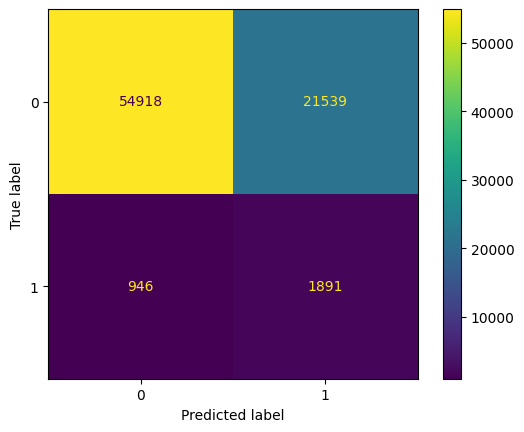

In [22]:
y_pred_cnn = CNN.predict(new_X_test)
y_pred_cnn.resize((y_pred_cnn.shape[0]))
y_pred_cnn_eval = (y_pred_cnn> 0.05).astype(int)
clf_report("CNN", y_pred_cnn_eval)
